# GAIT declaration

Github Copilot was used via an extension on VScode to write comments for all functions and suggest autocomplete options for code excerpts.

Running instructions on DCS computers:

'module load cs413-python' ensures all relevant libraries are installed locally, before running jupyter notebook

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function: `apply_clahe_to_rgb`

The apply_clahe_to_rgb function enhances local contrast in an RGB image by applying CLAHE (Contrast Limited Adaptive Histogram Equalisation) to each color channel individually and merging them back. Keeping all three colour channels preserved can increase the robustness of template matching, by providing additional data that distinguishes different areas of an image from each other, especially when the template in question contains a distinct red colour. 

This method improves details in areas with uneven lighting, avoiding the desaturation or over-enhancement that methods like the traditional histrogram equalisation may cause. Specifically the parameter 'clipLimit' is set at 0.1, reducing the degree of enhancement by clipping the histogram at 0.1. This makes it really effective for enhancing local contrast, making important features in both the template and scene more visible and distinct, even in regions with uneven lighting.

The 'tileGridSize' is set to (6,6). The choices to partition the image into 36 sections, where each section is processed independently using histogram equalisation, was made for efficiency. Smaller tile sizes (so larger values for 'tileGridSize') would have more precise contrast increase on each area and could improve results due to the generalised nature of the task, but in images with noise, this could introduce more noise, so a larger grid space that may miss small local features is sufficient and less computationally expensive.

Maintaining all three colour channels increases computational cost and memory usage, which could be a concern when processing large numbers of images, which is why larger tile sizes (so having few tiles) were chosen to ensure overall speed is not lost significantly.

In [2]:
def apply_clahe_to_rgb(image):
    """
    Applies CLAHE (Contrast Limited Adaptive Histogram Equalisation) to each channel of an RGB image.

    Parameters:
    image (numpy.ndarray): The input image in RGB format.

    Returns:
    numpy.ndarray: The image after applying CLAHE to each channel and merging them back.
    """
    channels = cv2.split(image)
    clahe = cv2.createCLAHE(clipLimit=0.1, tileGridSize=(6, 6))
    clahe_channels = [clahe.apply(channel) for channel in channels]
    merged = cv2.merge(clahe_channels)
    return merged

# Function: `preprocess_image`

During preprocessing a gaussian blur is applied to reduce noise, which helps to eliminate small, irrelevant details that could interfere with the matching process, allowing for a cleaner comparison between the template and the scene. The function performing CLAHE on coloured images is then called, producing an enhanced image.

In [3]:
def preprocess_image(image):
    """
    Preprocesses an input image by applying Gaussian blur followed by CLAHE.

    Parameters:
    image (numpy.ndarray): The input image in RGB format.

    Returns:
    numpy.ndarray: The preprocessed image with reduced noise and enhanced contrast.
    """
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    clahe_image = apply_clahe_to_rgb(blurred_image)
    return clahe_image

# Function: `scaled_templates`
The template and its corresponding mask are resized at various scales to handle potential size variations of the object in the scene, so that the template can match objects in the scene images that appear at different scales.

In [4]:
def scaled_templates(template, mask, scales):
    """
    Generates scaled versions of a template and its corresponding mask for multiple scaling factors.

    Parameters:
    template (numpy.ndarray): The input template image to be resized.
    mask (numpy.ndarray): The input mask image to be resized, corresponding to the template.
    scales (list of float): A list of scaling factors to apply to the template and mask.

    Returns:
    tuple: A tuple containing two lists:
        - new_templates: List of scaled template images.
        - new_masks: List of scaled mask images.
    """
    new_templates = []
    new_masks = []
    for scale in scales:
        new_template = cv2.resize(template, None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
        new_mask = cv2.resize(mask, None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
        new_templates.append(new_template)
        new_masks.append(new_mask)
    return new_templates, new_masks

# Function: `locate_rh_sign`

First, the function converts both the sign (template) and scene images to RGB to ensure color information is preserved, as this can be important for distinguishing key features in the images. 

Then the defined preprocessing function applies a gaussian blur and CLAHE enhancement.

To further improve the matching, a binary mask is generated for the template using thresholding, to only include dark regions of the image (by setting areas above the threshold of 100 to the value of 0) and exclude background or non-essential details (by setting areas below the threshold to 255), so that only the most important parts of the template are used during the final template match. The threshold value was manually tweaked by checking for the highest average 'highest_score' (the variable associated with how accurate the final template match is) across all the images. 

Tweaking this value impacts the performance of the template matching significantly, and keeping the threshold at 100 ensured the average 'highest_score' was above 0.74. Changing the threshold either decreased the average score (indicating worse performance across all images) or led to improved performance in some cases but caused failures in detecting specific images (also reducing average performance). This threshold was selected as a good compromise between accuracy and generalisability.

After this the resizing function is used to resize the template and its corresponding mask to various defined scales.

Morphological closing is then applied to both the enhanced template and the scene to smooth rough edges and fill small gaps that may have been introduced during resizing or preprocessing,  eliminating artifacts and creating more continuous and connected regions in both images.

To match the actual iamages, the functino uses template matching, using the cv2.TM_CCOEFF_NORMED method. This ensures the highest correlation between the template and the scene while ignoring masked regions. A bounding box is drawn in the colour green, as the colour that is most easily distinguished by the human eye.

In [5]:
def locate_rh_sign(sign_image, scene_image):
    """
    Locates a road sign (RH sign) in a scene image using template matching with preprocessing and multi-scale templates.

    Parameters:
    sign_image (numpy.ndarray): The template image of the road sign (BGR format).
    scene_image (numpy.ndarray): The scene image where the sign is to be located (BGR format).

    Returns:
    numpy.ndarray: The scene image with the detected sign highlighted by a rectangle.
    """
    template_rgb = cv2.cvtColor(sign_image, cv2.COLOR_BGR2RGB)
    scene_rgb = cv2.cvtColor(scene_image, cv2.COLOR_BGR2RGB)

    clahe_template = preprocess_image(template_rgb)
    clahe_scene = preprocess_image(scene_rgb)

    _,mask = cv2.threshold(clahe_template, 100, 255, cv2.THRESH_BINARY_INV)

    scales =  [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3] 
    templates, masks = scaled_templates(clahe_template, mask, scales)

    kernel = np.ones((3, 3))
    morph_scene = cv2.morphologyEx(clahe_scene, cv2.MORPH_CLOSE, kernel)
    for template in templates:
        template = cv2.morphologyEx(template, cv2.MORPH_CLOSE, kernel)

    highest_score  = -1
    best_location = None
    best_template = None

    for template in templates:
        for mask in masks:
            #ensures the template is only tested with its corresponding sized mask
            if template.shape[1] == mask.shape[1]: 
                result = cv2.matchTemplate(morph_scene, template, cv2.TM_CCOEFF_NORMED, mask = mask)
                _, temp, _, location = cv2.minMaxLoc(result)
            
                if temp > highest_score:
                    highest_score = temp
                    best_template = template
                    best_location = location
                    
    if best_location:
        #print(max_val_after)      #testing performance after each preprocessing step
        height, width = best_template.shape[:2]
        tl_coords = best_location
        br_coords = (tl_coords[0] + width, tl_coords[1] + height)

        cv2.rectangle(scene_image, tl_coords, br_coords, (0, 250, 0), 2)

        plt.figure()
        plt.title('Located sign')
        plt.imshow(cv2.cvtColor(scene_image, cv2.COLOR_BGR2RGB))
        plt.show()
    else:
        print("No sign found.")

    return scene_image

# Code usage demo:

This code demonstrates how to use the `locate_rh_sign` function. The data directory containing the images is specified as `./data`. The template image of the road sign (`rh_sign.jpg`) is loaded. The `locate_rh_sign` function is called iteratively for each scene image (`img1.png`, `img2.png`, ..., `img5.png`).

A challenge encountered initially was that the image was converted to grayscale and CLAHE was applied to the single channel. However, this approach led to incorrect matches due to the loss of color data. To address this, CLAHE was instead applied individually to each RGB channel, preserving the color information. Also issues in scale invariance required the manual resizing of the template image to different scales. By preprocessing both the template and scene and focusing on only unmasked template areas, the function maximises the likelihood of accurate matching, and is accommodating for variations in scale, noise, and lighting.
  
A key failure in this code is the bounding box drawing. The bounding box is drawn based on the angle of the template image, resulting in a completely upright bounding box. As this box does not account for variances in angles, scenes that contain particularly angled signs will still have an upright box drawn on, instead of at the exact angle of the box, potentially resulting in the bounding box clipping the edges of the sign instead of being completely correct. Another key failure of this code is the inability to process images with multiple road signs, or for systems with the signs significantly obscured. 


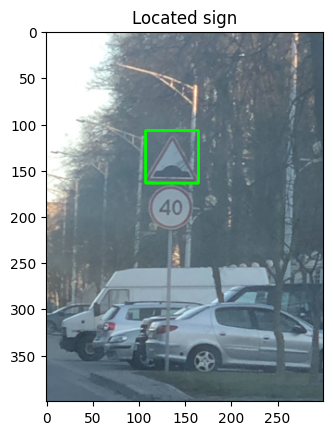

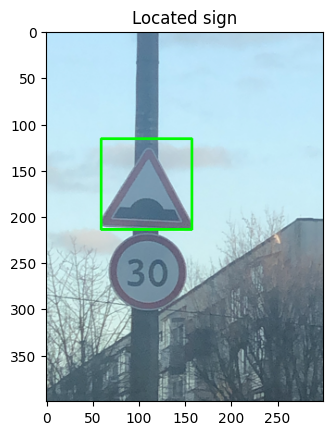

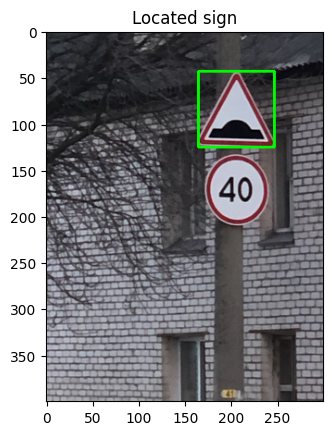

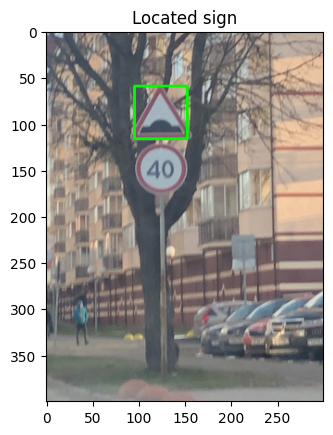

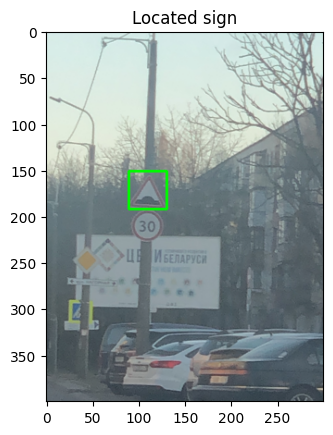

In [6]:
data_dir = "./data"  
sign_image = cv2.imread(data_dir + "/Task-1/rh_sign.jpg")

scene_image = cv2.imread(data_dir + "/Task-1/img1.png")
result_image = locate_rh_sign(sign_image, scene_image)

scene_image = cv2.imread(data_dir + "/Task-1/img2.png")
result_image = locate_rh_sign(sign_image, scene_image)

scene_image = cv2.imread(data_dir + "/Task-1/img3.png")
result_image = locate_rh_sign(sign_image, scene_image)

scene_image = cv2.imread(data_dir + "/Task-1/img4.png")
result_image = locate_rh_sign(sign_image, scene_image)

scene_image = cv2.imread(data_dir + "/Task-1/img5.png")
result_image = locate_rh_sign(sign_image, scene_image)

# Function: `color_channels`
Each color channel can have different spatial frequency characteristics, and their frequency-domain information may differ so to be able to extract DFTs of an image, it is crucial to process each colour channel individually. This function simply splits an image into its individual RGB components.

In [7]:
def color_channels(img):
    """
    Extracts the red, green, and blue channels from the input image.
    
    Parameters:
        img (numpy.ndarray): RGB image.
    
    Returns:
        tuple: Red, green, and blue channels.
    """
    return img[:, :, 0], img[:, :, 1], img[:, :, 2]

# Function: `create_gabor_filters`
This function creates gabor filters across a given range of factors. The range of orientations are from 135 degrees to 225 degrees at increments of about 5 degrees, accounting for the range of vertical lines supplied in the airport image.

In [603]:
def create_gabor_filters(ksize=31, theta_range=(3/4)*np.pi, end_theta=(5/4)*np.pi, step=np.pi/36, sigmas=[3, 5], lamdas=[20, 25]):
    """
    Creates a bank of Gabor filters with varying parameters.

    Parameters:
    ksize (int): Size of the Gabor kernel (square kernel with dimensions `ksize x ksize`).
    theta_range (float): Starting angle (in radians) for the filter orientation.
    end_theta (float): Ending angle (in radians) for the filter orientation.
    step (float): Step size (in radians) for iterating through orientations.
    sigmas (list of float): List of standard deviations for the Gaussian envelope.
    lamdas (list of float): List of wavelengths (lambda) of the sinusoidal factor.

    Returns:
    list: A list of 2D NumPy arrays, each representing a Gabor kernel.
    """    
    
    filters = []
    for theta in np.arange(theta_range, end_theta, step):
        for sigma in sigmas:
            for lamda in lamdas:
                kern = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma=1.5, psi=0)
                filters.append(kern)
    return filters

# Function: `apply_gabor_filters`
This function applies the gabor filters on a single colour channel of an image, and preserves the maximum feature response (measured in terms of magnitude) from each filter. Then the image is normalised before being returned.

In [604]:
def apply_gabor_filters(img_channel, filters):
    """
    Applies a set of Gabor filters to a single color channel of an image and combines the results.

    Parameters:
    img_channel (numpy.ndarray): A single color channel (2D array) of the image (e.g., Red, Green, or Blue).
    filters (list of numpy.ndarray): A list of Gabor filter kernels to apply to the image channel.

    Returns:
    numpy.ndarray: The image channel after applying the Gabor filters, normalised to the range [0, 255].
    """
    filtered_img = np.zeros_like(img_channel, dtype=np.float32)
    for kern in filters:
        filtered = cv2.filter2D(img_channel, cv2.CV_32F, kern)
        filtered_img = np.maximum(filtered_img, filtered)
    return cv2.normalize(filtered_img, None, 0, 255, cv2.NORM_MINMAX)

# Function: `display_images`
A simple function to display multiple images together, especially important during testing.

In [605]:
def display_images(images, titles, cmap='gray', figsize=(15, 5)):
    """
    Displays multiple images in a single figure with corresponding titles.

    Parameters:
    images (list of numpy.ndarray): List of images (2D or 3D NumPy arrays) to display.
    titles (list of str): List of titles corresponding to each image.
    cmap (str): The color map to use for displaying images (default is 'gray' for grayscale images).
    figsize (tuple): The size of the figure (default is (15, 5)).
    """
    plt.figure(figsize=figsize)
    for i, (image, title) in enumerate(zip(images, titles), 1):
        plt.subplot(1, len(images), i)
        plt.imshow(image, cmap=cmap)
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Function: `magnitude_spectrum`
This function computes the magnitude spectrum of a Fourier-transformed image

In [606]:
def magnitude_spectrum(fft_image):
    """
    Computes the magnitude spectrum of a Fourier-transformed image.

    Parameters:
    fft_image (numpy.ndarray): The Fourier-transformed image (complex-valued).

    Returns:
    numpy.ndarray: The magnitude spectrum of the Fourier-transformed image, scaled for visualisation.
    """
    return 20 * np.log(np.abs(fft_image) + 1)

# Function: `fourier_transform`
The function performs a 2D Fourier Transform on a given image channel, to transform it to the frequency domain from the spatial domain, and then applies a shift operation to move the zero-frequency component to the center of the spectrum to make it easier to perform analysis on the frequency spectrum later on.

In [607]:
def fourier_transform(img_channel):
    """
    Applies the 2D Fourier Transform to a single image channel and shifts the zero-frequency component to the center.

    Parameters:
    img_channel (numpy.ndarray): A single image channel (2D array), typically a grayscale or color channel (e.g., Red, Green, Blue).

    Returns:
    numpy.ndarray: The 2D Fourier-transformed image, with the zero-frequency component shifted to the center.
    """
    fft_image = np.fft.fft2(img_channel)
    return np.fft.fftshift(fft_image)

# Function: `create_binary_mask`
This function creates a binary mask based on parameters that determine its size and location, setting a rectangular region of the mask to 1, while the rest of the mask remains 0.

In [608]:
def create_binary_mask(height, width, start_x, end_x, start_y, end_y):
    """
    Creates a binary mask with a rectangle of ones in the specified region.

    Parameters:
    height (int): The height of the mask.
    width (int): The width of the mask.
    start_x (int): The starting x-coordinate (column index) of the rectangle.
    end_x (int): The ending x-coordinate (column index) of the rectangle.
    start_y (int): The starting y-coordinate (row index) of the rectangle.
    end_y (int): The ending y-coordinate (row index) of the rectangle.

    Returns:
    numpy.ndarray: A binary mask with ones in the specified rectangular region and zeros elsewhere.
    """
    mask = np.zeros((height, width), dtype=np.float32)
    mask[start_y:end_y, start_x:end_x] = 1
    return mask

# Function: `butterworth_low_pass_filter`
This function creates a low pass butterworth filter, which filters for frequencies above a certain cutoff. Any frequency below the cutoff is able to pass through, while frequencies above the cutoff are blocked.

In [609]:
def butterworth_low_pass_filter(height, width, cutoff_frequency, order):
    """
    Generates a Butterworth low-pass filter.

    Parameters:
    height (int): The height of the filter.
    width (int): The width of the filter.
    cutoff_frequency (float): The cutoff frequency of the low-pass filter.
    order (int): The order of the Butterworth filter. A higher order results in a sharper cutoff.

    Returns:
    numpy.ndarray: The Butterworth low-pass filter (frequency domain).
    """
    x = np.linspace(-width, width, width)
    y = np.linspace(-height, height, height)
    X, Y = np.meshgrid(x, y)
    D = np.sqrt(X**2 + Y**2)  # Distance from the center
    H = 1 / (1 + (D / cutoff_frequency)**(2 * order))
    return H

# Function: `task2`
The function is designed to remove harsh horizontal black blinds from an image by specifically targeting their frequency components. First the function separates the image into its red, green, and blue channels and gabor filters are then applied to enhance the horizontal lines associated with the blinds. These filters emphasise the relevant frequency components, making it easier to identify which parts of the frequency domain contribute to the undesired artifacts when a Fourier Transform is performed.

A binary mask is then created to isolate the main image data, which is concentrated at the center of the magnitude spectrum because of the Fourier shift. Additionally, a Butterworth low-pass filter is applied to this region, selectively removing frequencies above a chosen threshold. In this implementation, a threshold of 220 was selected, balancing the need to eliminate artifacts while preserving the majority of the image's details. While lowering this threshold can completely remove the blinds, it may also degrade the image quality significantly, potentially making it difficult to extract any meaningful visual information from the resulting image.

Finally, the filtered frequency data is transformed back into the spatial domain using the inverse Fourier Transform. The resulting image is then normalised to adjust its intensity values for visualisation. This reduces the visual impact of the black blinds while preserving as much of the original image detail as possible, though it is a compromise between artifact removal and image quality.

In [8]:
def task2(image):
    """
    This function processes an input image by performing various steps:
    1. Displays the original image.
    2. Extracts and processes the color channels.
    3. Applies Gabor filters to each color channel.
    4. Applies the Fourier Transform to each channel and displays their magnitude spectra.
    5. Applies a Butterworth low-pass filter with a binary mask for frequency filtering.
    6. Applies inverse Fourier Transform to obtain the filtered image and displays it.

    Parameters:
    image (numpy.ndarray): The input image (BGR format) to be processed.
    """
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(8, 8))
    plt.imshow(img_rgb)
    plt.title("Original Image")
    plt.axis("off")
    plt.show()

    red_channel, green_channel, blue_channel = color_channels(img_rgb)

    filters = create_gabor_filters()
    gabor_responses = [
        apply_gabor_filters(channel, filters) 
        for channel in (red_channel, green_channel, blue_channel)
    ]

    fft_channels = [fourier_transform(channel) for channel in (red_channel, green_channel, blue_channel)]
    magnitude_spectra = [magnitude_spectrum(fft) for fft in fft_channels]
    display_images(magnitude_spectra, ["Red - Magnitude Spectrum", "Green - Magnitude Spectrum", "Blue - Magnitude Spectrum"])

    height, width = img_rgb.shape[:2]
    maskbinary = create_binary_mask(height, width, 270, 450, 435, 525)
    
    cutoff_frequency = 250 
    order = 1              
    
    masklowpass = butterworth_low_pass_filter(height, width, cutoff_frequency, order)
    mask = maskbinary * masklowpass
    
    filtered_channels = [fft * mask for fft in fft_channels]
    filtered_magnitudes = [magnitude_spectrum(fft) for fft in filtered_channels]
    display_images(filtered_magnitudes, ["Filtered Red Spectrum", "Filtered Green Spectrum", "Filtered Blue Spectrum"])

    filtered_images = [np.fft.ifft2(np.fft.ifftshift(fft)) for fft in filtered_channels]
    combined_image = np.stack([np.real(img) for img in filtered_images], axis=2)
    combined_image = cv2.normalize(combined_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    plt.figure(figsize=(8, 8))
    plt.imshow(combined_image)
    plt.title("Low-pass Filtered Image")
    plt.axis("off")
    plt.show()


# Code usage demo:
This code demonstrates how to use the `task2` function. The airport image is read using the previously defined data_dir string. The outputs contain the original image, the post-gabor filter magnitude spectrum, the processed magnitude spectrum, and the image produced from the processed frequency spectrum. 

Warning: There may be a slight delay between the original image, and the magnitude spectrums output as this function is computationally expensive.

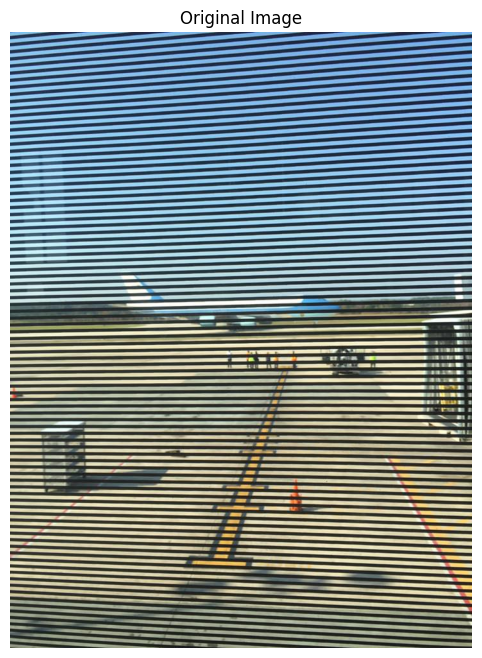

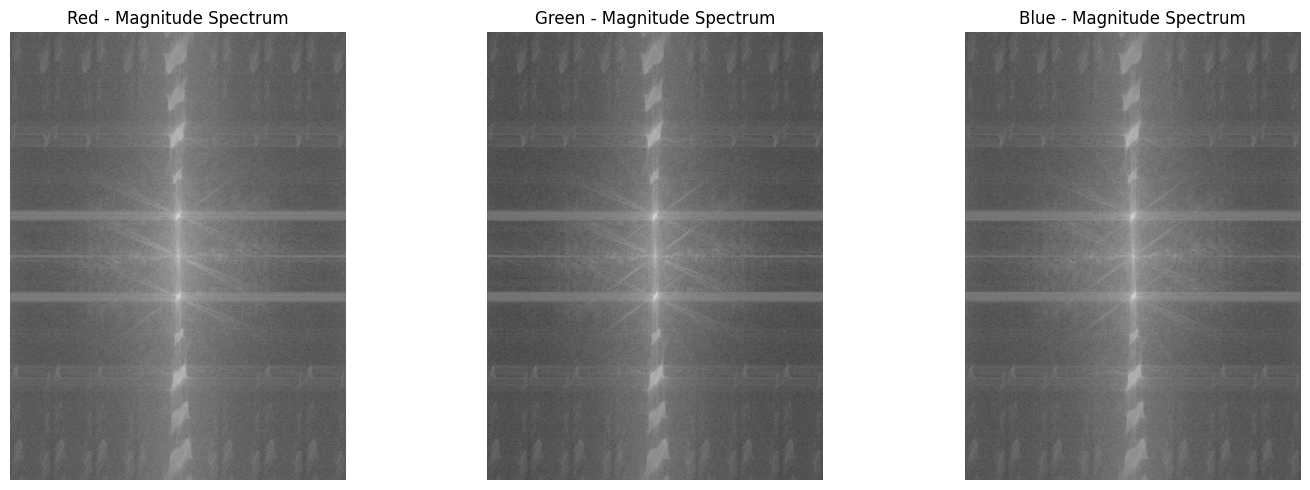

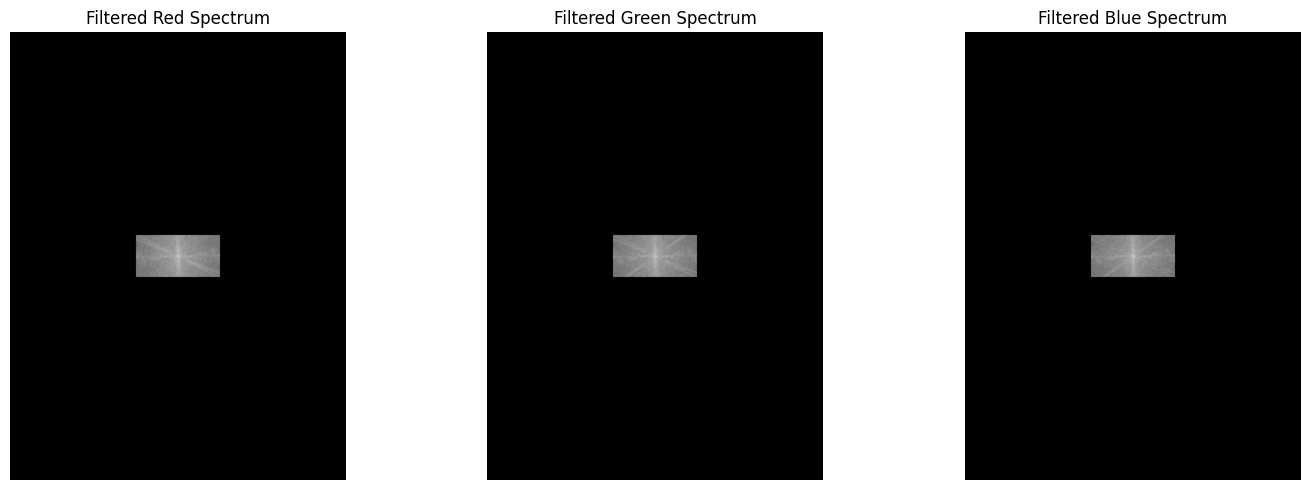

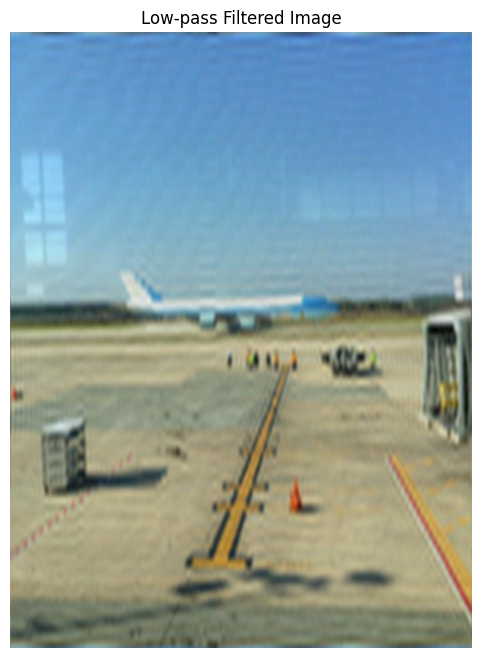

In [611]:
airport_image = cv2.imread(data_dir + "/Task-2/AF1.jpg")
task2(airport_image)

# Function: `crop_borders`
This function is simply to crop any excessive black or white borders from an image, that may be caused due to the way different systems load images in. 

In [11]:
def crop_borders(image):
    """
    Crop black/white borders from an image.

    Parameters:
    image (numpy.ndarray): The input image (HxWxC or HxW) with black borders.

    Returns:
    numpy.ndarray: The final resized image.
    
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    x, y, w, h = cv2.boundingRect(contours[0])
    cropped_image = image[y:y+h, x:x+w]
    return cropped_image


# Function: `expand_image`

Removes borders and resizes images to a certain given size.

In [12]:
def expand_image(image):
    """
    Removes black borders from a squished image and resizes the image.

    Parameters:
    image (numpy.ndarray): The input image (HxWxC or HxW) with black borders.

    Returns:
    numpy.ndarray: The final resized image.
    """
    #original_height, original_width = image.shape[:2]
    original_height, original_width = 290,290
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    
    _, binary = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        raise ValueError("No non-black region detected in the image.")
        
    x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
    cropped_image = image[y:y+h, x:x+w]
    resized_image = cv2.resize(cropped_image, (original_width, original_height), interpolation=cv2.INTER_LINEAR)

    blurred = cv2.GaussianBlur(resized_image, (5, 5), 0)
    sharpened = cv2.addWeighted(resized_image, 1.5, blurred, -0.5, 0)
    
    return(resized_image)

# Function: `align_images`

This function aligns a source image to a target image and selects whether manual or automatic aligment will happen. Based on this selection the function preprocesses an image to optimise matching later on. This largely involves resizing the image. Both function work differently. 

If manual is selected an image pop-up shows up, where the user can enter as many points as they would like. These points are marked in red for the user, but the order of the points is key, and a user must remember the order of points selected on the first image, and attempt to recreate that on the following image.

If automatic is selected ORB feature detection is used, along with the Brute force matcher to match points between both images. Initially sift was used, which usually keeps more data but sift performance for blurred images was worse. 

Then the mathematical transformation operation is applied with warpAffine, after computing the transformation matrix. The final images are displayed.

In [21]:
def align_images(source, target, selection="automatic"):
    """
    Align the source image to the target image using manual or automatic correspondence selection.

    Parameters:
    source (ndarray): Source image to be aligned.
    target (ndarray): Target image to align to.
    selection (str): "manual" or "automatic" for correspondence point selection.

    Returns:
    aligned_image (ndarray): Aligned source image.
    """

    if selection == "manual":
        source = crop_borders(source)
        target = crop_borders(target)
        print("Please manually select corresponding points in the images.")
        points_source = []
        points_target = []

        def click_points(event, x, y, flags, param):
            points, image, color, name = param
            if event == cv2.EVENT_LBUTTONDOWN:
                points.append((x, y))  
                cv2.circle(image, (x, y), 5, color, -1)  
                cv2.imshow(name, image)  

        source_copy = source.copy()
        target_copy = target.copy()

        cv2.imshow("Source", source_copy)
        cv2.setMouseCallback("Source", click_points, param=(points_source, source_copy, (0, 0, 255),"Source"))  # Red circles for source

        cv2.waitKey(0) 

        cv2.imshow("Target", target_copy)
        cv2.setMouseCallback("Target", click_points, param=(points_target, target_copy, (0, 255, 0), "Target"))  # Green circles for target

        cv2.waitKey(0)  
        cv2.destroyAllWindows()  

        points_source = np.array(points_source, dtype=np.float32)
        points_target = np.array(points_target, dtype=np.float32)


    elif selection == "automatic":
        source = expand_image(source)
        orb = cv2.ORB_create()
        kp1, des1 = orb.detectAndCompute(source, None)
        kp2, des2 = orb.detectAndCompute(target, None)

        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        matches = bf.match(des1, des2)
        matches = sorted(matches, key=lambda x: x.distance)
        midpoint = len(matches)//2

        points_source = np.float32([kp1[m.queryIdx].pt for m in matches[:midpoint]]).reshape(-1, 1, 2)
        points_target = np.float32([kp2[m.trainIdx].pt for m in matches[:midpoint]]).reshape(-1, 1, 2)
    else:
        raise ValueError("Invalid selection method. Choose 'manual' or 'automatic'.")

    M, _ = cv2.estimateAffine2D(points_source, points_target)

    height, width, _ = target.shape
    aligned_image = cv2.warpAffine(source, M, (width, height))

    plt.figure(figsize=(15, 8))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(source, cv2.COLOR_BGR2RGB))
    plt.title("Source Image")

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(target, cv2.COLOR_BGR2RGB))
    plt.title("Target Image")

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(aligned_image, cv2.COLOR_BGR2RGB))
    plt.title("Aligned Image")

    plt.show()
    
    return aligned_image

# Code usage demo:

An example of loading in the target image, and two sources to be aligned. The user must specifically specify selection between "manual" or "automatic" and is not forgiving with capital letters of mistakes in spelling.

Both the automatic and manaul functions use the affine transformation matrix, which means the outputted image relies entirely on the points selected by the user or detected by the function. For the manual image, when a user selects 4-6 points the outputs are printed below. More points increase the accuracy of the final image, especially when a range of points are selected from across the image (from corners to more central points). 

The automatic selection has points automatically detected. This process results in many potential matches. These are then sorted in order of best match, and the first half of the matches are taken. This takes the half of the array with the best matches, reducing processing time, and removing matches with high likelihood of being less accurate. However this doesnt guarantee the removal of all inaccurate points, and ORB is likely to detect some points incorrectly. 

This implies automatic selection will not be as accurate as manual selection. However user error can cause similar inaccuracies in manual detection. A user is unlikely to pick the exact coordinates that precisely match, for every selection. Both methods have their own range for error, even if automatic processing is more liekly to contain inaccuracies.

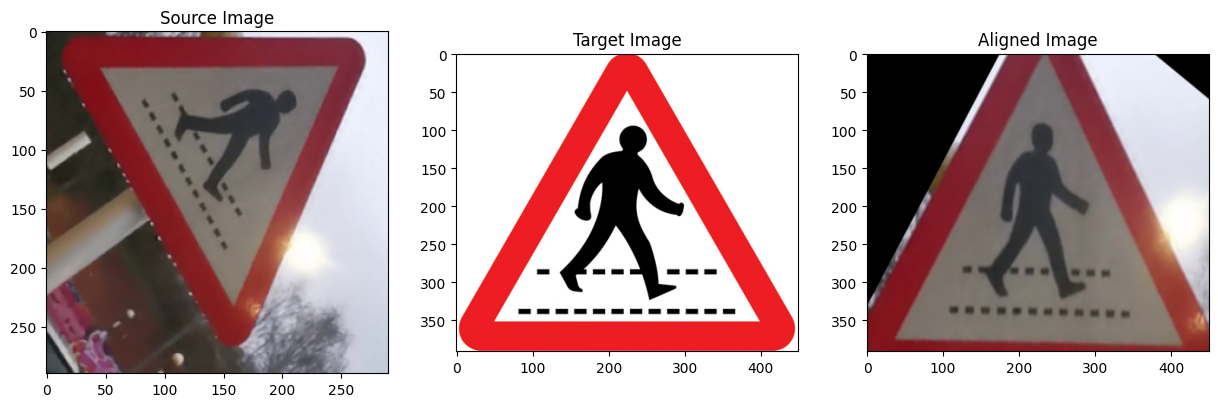

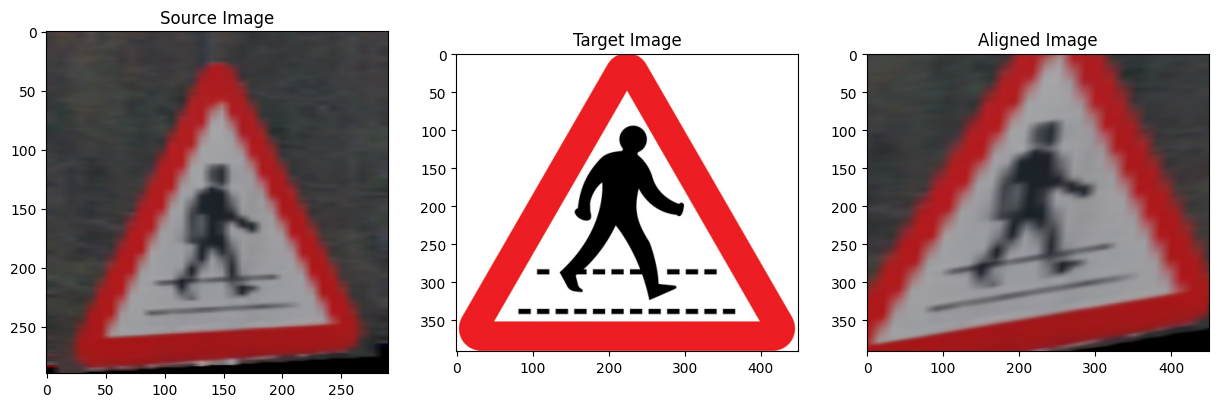

In [22]:
target = cv2.imread(data_dir + "/Task-3/" + "zebra_crossing_reference.jpg")
source1 = cv2.imread(data_dir + "/Task-3/" + "zebra_crossing1.png")
source2 = cv2.imread(data_dir + "/Task-3/" + "zebra_crossing2.png")

aligned_auto = align_images(source1, target, selection="automatic")

aligned_auto = align_images(source2, target, selection="automatic")

Key points for manual selection:

-User can pick as many points as they would like on the source image

-Once the selection is complete, and the user is aware of the ORDER of the points, the user may hit the zero (0) key to exit the image

-This will prompt a user to select points on the target image

-Move the screens around  to have both screens open at the same time

-Ensure the same points, in the same order are entered

Please manually select corresponding points in the images.


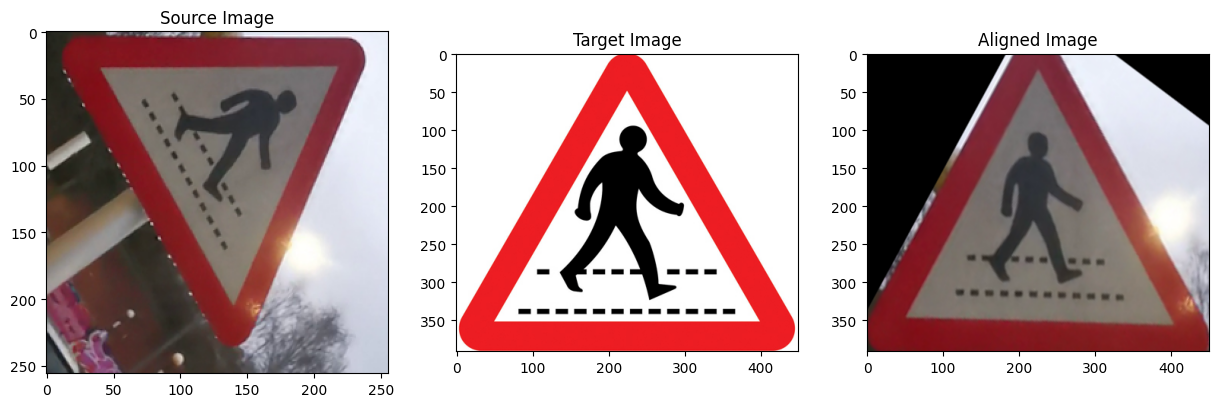

In [34]:
# Align images using automatic feature matching
aligned_auto = align_images(source1, target, selection="manual")

Please manually select corresponding points in the images.


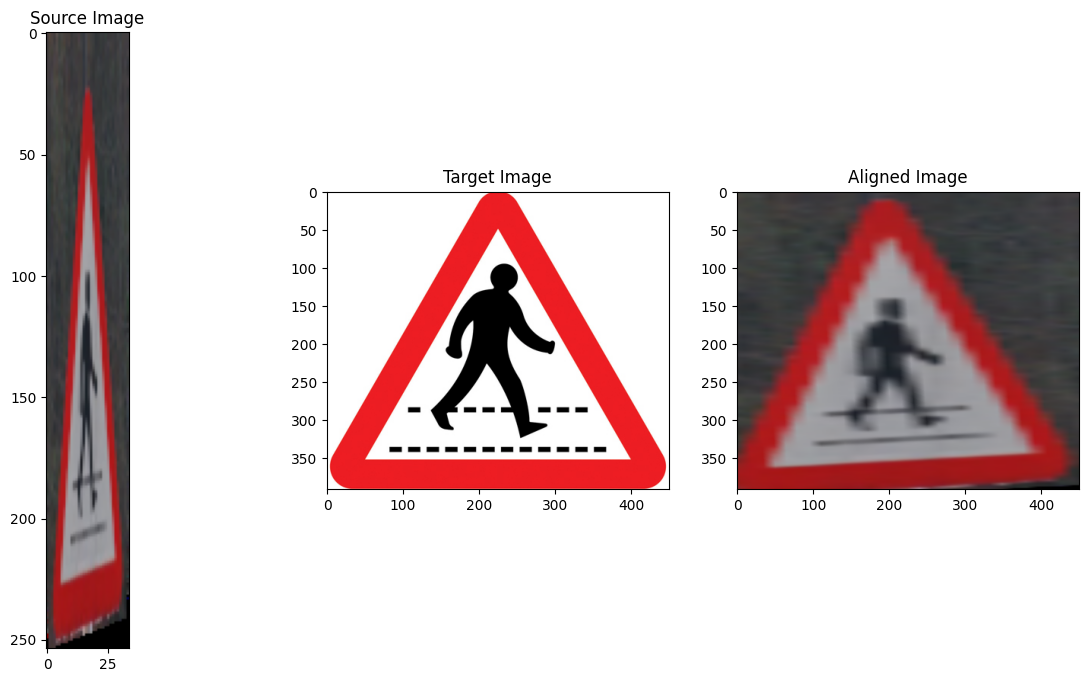

In [36]:
# Align images using automatic feature matching
aligned_auto = align_images(source2, target, selection="manual")

# Function: `apply_clahe_to_rgb`

This function enhances local contrast in an RGB image by applying CLAHE to each color channel individually and merging them back. Keeping all three colour channels is crucial when using colour masks to distinguish red signs from backgrounds.

CLAHE improves details in areas with uneven lighting, avoiding the desaturation or over-enhancement that methods like the traditional histrogram equalisation may cause. Specifically the parameter 'clipLimit' is set as a variable 'clip', so this can be altered for different situations, or scenes with different levels of noise.

The tileGridSize is set to (8,8). The choices to partition the image into 64 sections, where each section is processed independently using histogram equalisation, ensuring enough contrast, without introducing more noise into the image.

Maintaining all three colour channels increases computational cost and memory usage, which could be a concern when processing large numbers of images, which is why larger tile sizes (so having few tiles) were chosen to ensure overall speed is not lost significantly.

In [612]:
def apply_clahe_to_rgb(image, clip):
    """
    Applies CLAHE to each channel of an RGB image.

    Parameters:
    image (numpy.ndarray): The input image in RGB format.
    clip (float): The clip limit for CLAHE. This parameter controls the contrast enhancement.

    Returns:
    numpy.ndarray: The image after applying CLAHE to each channel and merging them back.
    """
    if len(image.shape) == 3 and image.shape[2] == 3:
        channels = cv2.split(image)
        clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=(8,8))
        clahe_channels = [clahe.apply(channel) for channel in channels]
        return cv2.merge(clahe_channels)
    else:
        raise ValueError("Input image must be an RGB image with 3 channels.")


# Function: `make_mask`

This function creates a mask for the image based on color values supplied in the main function, using the HSV color space for more precise thresholding. Using HSV allows for better separation of color components—particularly hue—while accounting for variations in brightness and saturation. In the HSV space, red hues span two regions due to the way color is represented, so two separate masks are created to cover these distinct red ranges in the hue channel. By combining these two masks, the function ensures that all shades of red are effectively captured, even if they fall across different ranges in the color space.

Morphological operations such as opening and closing are applied to the mask to enhance the quality. Opening removes small noise and isolated pixels from the mask, while closing fills small gaps and holes within objects, especially in cases where the red sign regions may be partially obscured. These operations help smooth the mask, ensuring that it accurately reflects the true boundaries of the red regions without being affected by small imperfections or artifacts.

After the mask is refined, the function uses edge detection with the Canny algorithm to identify the boundaries of the red regions. It then extracts the contours from these edges using the cv2.findContours function. The cv2.approxPolyDP method is applied to approximate the shape of each contour, specifically focusing on triangular shapes by checking for contours with three vertices. Here, the epsilon is set to 0.03, so the resulting polygon will have an approximation error set to 3% of the contours perimeter. This value preserves most of the contours original shape, and a larger value of epsilon simplifies the contours more, giving a more smoothed look, 3% was chosen as an increase in this value oversimplifies the contours, reducing accuracy of the final segmentation significantly.  

In [613]:
def make_mask(image,lower_red1,upper_red1,lower_red2,upper_red2, clip):
    """
    Generates a mask highlighting red-colored regions and detects triangular shapes in the image.

    This function applies CLAHE to enhance the contrast, converts the image to HSV color space, 
    and creates a mask to detect red regions. It then applies morphological operations to clean 
    the mask, detects edges, and identifies contours in the image. The function looks for 
    triangular shapes in the contours and returns a final mask with the detected triangles.

    Parameters:
    image (numpy.ndarray): The input image in RGB format.
    lower_red1 (tuple): The lower bound of the red color range for the first red region in HSV space.
    upper_red1 (tuple): The upper bound of the red color range for the first red region in HSV space.
    lower_red2 (tuple): The lower bound of the red color range for the second red region in HSV space.
    upper_red2 (tuple): The upper bound of the red color range for the second red region in HSV space.
    clip (float): The clip limit for CLAHE, controlling the contrast enhancement applied to the image.

    Returns:
    numpy.ndarray: A mask with detected triangular red regions, where the triangles are filled with white (255).
    numpy.ndarray: The edge-detected image from Canny edge detection, used for contour detection.

    Raises:
    ValueError: If the input image does not have 3 channels (i.e., it is not an RGB image).
    """
    
    image_clahe = apply_clahe_to_rgb(image, clip)

    hsv = cv2.cvtColor(image_clahe, cv2.COLOR_RGB2HSV)

    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    mask = cv2.bitwise_or(mask1, mask2)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    edges = cv2.Canny(mask, 50, 200)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    mask_final = np.zeros_like(mask)
    for contour in contours:
        epsilon = 0.03 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        if len(approx) == 3:
            cv2.drawContours(mask_final, [contour], -1, 255, thickness=cv2.FILLED)

    return mask_final, edges

# Function: `segment_warning_road_sign`

This function is designed to segment and extract warning road signs from an image using color thresholding, contour detection, and if necessary, the Hough Transform. After converting the image to the RGB space and blurring the image to reduce noise, a mask is defined based on general red hues found in road signs. The created mask is applied to the image using a bitwise AND operation, but if the resulting segmentation does not detect anything, the image is then fed through a mask containing a wider range of potential red colours. The range of red this covers is darker and covers more orange and brown shades too, as defined by lower HSV numbers. With this new mask, a Hough transform is applied to detect straight lines in the image, and to use these lines to produce a convex hull. This hull is then filled into the mask, and segmentation is attempted again. 

In [614]:
def segment_warning_road_sign(image):
    """
    Segments warning road signs in an input image based on color and shape detection.

    Parameters:
    image (numpy.ndarray): The input image in BGR format (as read by OpenCV).

    Returns:
    tuple:
        numpy.ndarray: A binary mask (`mask_final`) where the segmented road sign is white (255) and the rest is black (0).
        numpy.ndarray: An image (`segmented`) where only the segmented road sign region is visible, and the rest is blacked out.
        
    """
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image_gaussian = cv2.GaussianBlur(image_rgb, (7, 7), 0)
    
    lower_red1, upper_red1 = np.array([0, 100, 100]), np.array([3, 255, 255])
    lower_red2, upper_red2 = np.array([174, 100, 100]), np.array([180, 255, 255])

    mask_final, edges = make_mask(image_gaussian,lower_red1,upper_red1,lower_red2,upper_red2, 3.0)

    segmented = cv2.bitwise_and(image_rgb, image_rgb, mask=mask_final)

    if not np.any(segmented):
    
        lower_red1, upper_red1 = np.array([0, 40, 40])  , np.array([10, 255, 255])
        lower_red2, upper_red2 = np.array([150, 40, 40]), np.array([180, 255, 255])

        mask_final, edges = make_mask(image_rgb,lower_red1,upper_red1,lower_red2,upper_red2, 3.5)
                
        lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=7, minLineLength=5, maxLineGap=10)
        if lines is not None:
            points = np.array([(line[0][0], line[0][1], line[0][2], line[0][3]) for line in lines]).reshape(-1, 2)
            hull = cv2.convexHull(points)
            cv2.fillConvexPoly(mask_final, hull, 255)
            segmented = cv2.bitwise_and(image_rgb, image_rgb, mask=mask_final)

    return mask_final, segmented

# Function: `display_segmentation_results`

Simple display image function, to display the results for each inputted image.

In [615]:
def display_segmentation_results(original_img, mask, segmented_img):
    """
    Displays the original image, segmentation mask, and segmented foreground side by side using Matplotlib.

    Parameters:
    original_img (numpy.ndarray): The input image in BGR format (as read by OpenCV).
    mask (numpy.ndarray): The binary segmentation mask where the region of interest is highlighted.
    segmented_img (numpy.ndarray): The segmented image where only the region of interest is visible.
    
    """
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title('Segmentation Mask')
    plt.imshow(mask, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Segmented Foreground')
    plt.imshow(segmented_img)
    plt.axis('off')
    
    plt.show()

# Code usage demo:
This cell demonstrates the use of the segment_warning_road_sign function, after reading in the relevant images.

Colour thresholding was a challenge, as road signs can contain a large range or reds based on various factors, such as brightness and saturations. However using this entire range of reds could pick up unnecessary noise or information from the background of images, leading to incorrect segmentation, so multiple masks were necessary, tailored for use in different situations. 

The model really struggles in images where a large amount of the background is also red, or within the red colour range defined in the masks. This can lead to somewhat incorrect segmentation, as parts of the background may be mistakenly included in the mask. 

In this case, the segmented edges are often not smooth, and background noise can introduce stray pixels into the mask. Instead, additional techniques like using template matching with example images of warning road signs or methods like SIFT matching could enhance accuracy and reduce false positives.

The performance of this method was evaluated in terms of execution time and segmentation quality. Visually, a ground truth image can be visually drawn and pixel accuracy between the two can be measured. The closer the segmented image is to the ground truth image in terms of percentage of pixels matching, the better the performance. This can be measured similarly using Intersection over Union (IoU), which measures the overlap between the ground truth mask and the predicted mask.

The IoU values are printed after the segmentation masks, in the same order as segmented images printed out, including the generated segmentation mask compared to the ground truth segmentation mask. The ground truth mask was hand drawn, and is not entirely accurate, but acts as a good indicator for accuracy. Here the IoUs were all consistently in the high 90s with the lowest being 0.95, indicating a successful segmentation. 


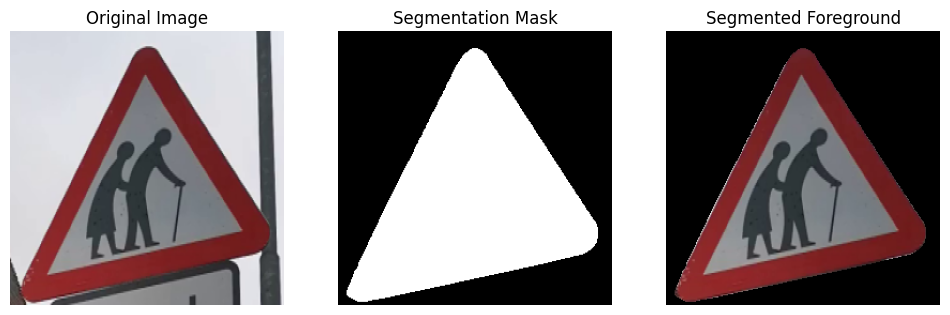

Processing time for frail.png: 0.0086 seconds


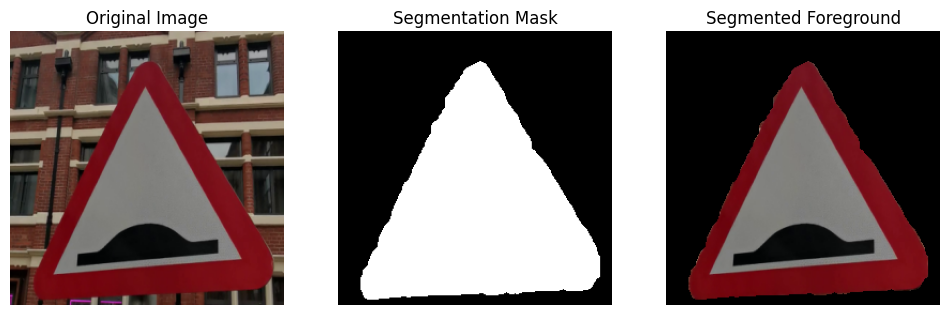

Processing time for road_humps_1.png: 0.0033 seconds


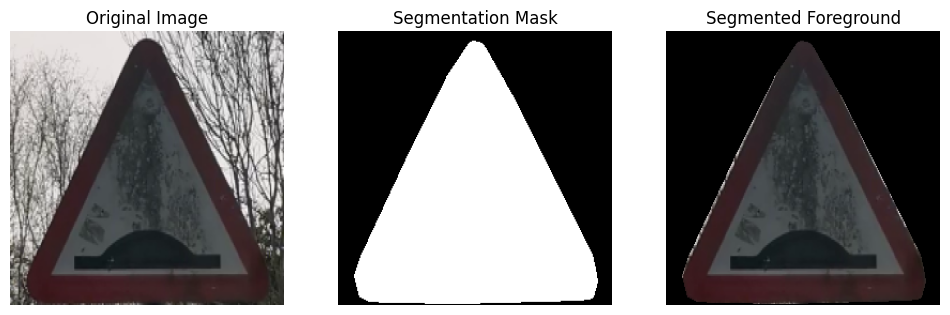

Processing time for road_humps_2.png: 0.0065 seconds


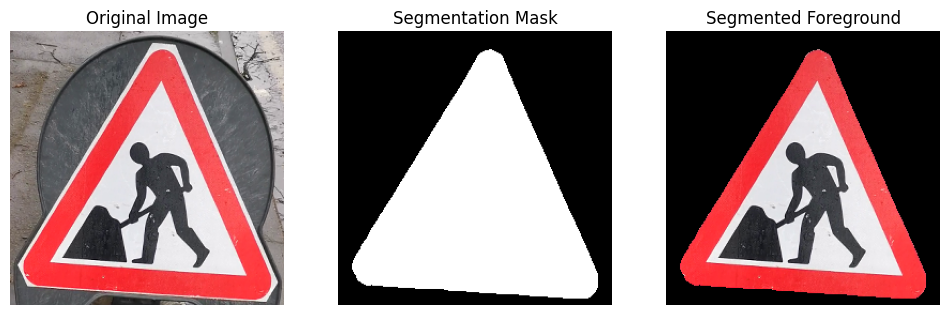

Processing time for road_works.png: 0.0033 seconds


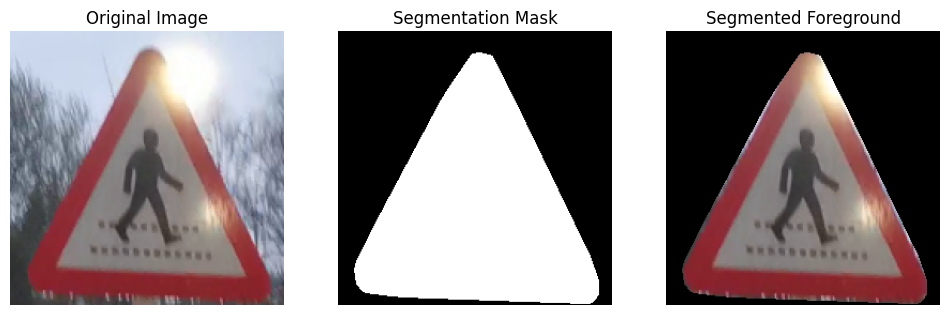

Processing time for zebra_crossing.png: 0.0040 seconds

Performance Evaluation:
IoU for frail-groundtruthmask.png: 0.98


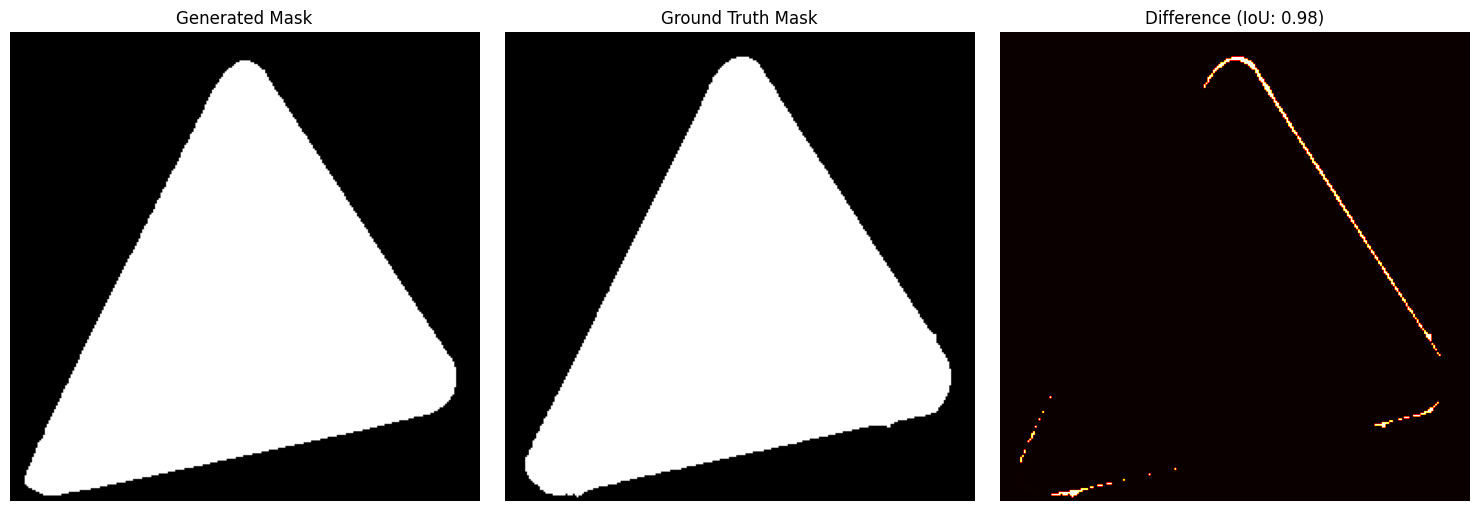


Performance Evaluation:
IoU for road_humps_1_groundtruth.png: 0.97


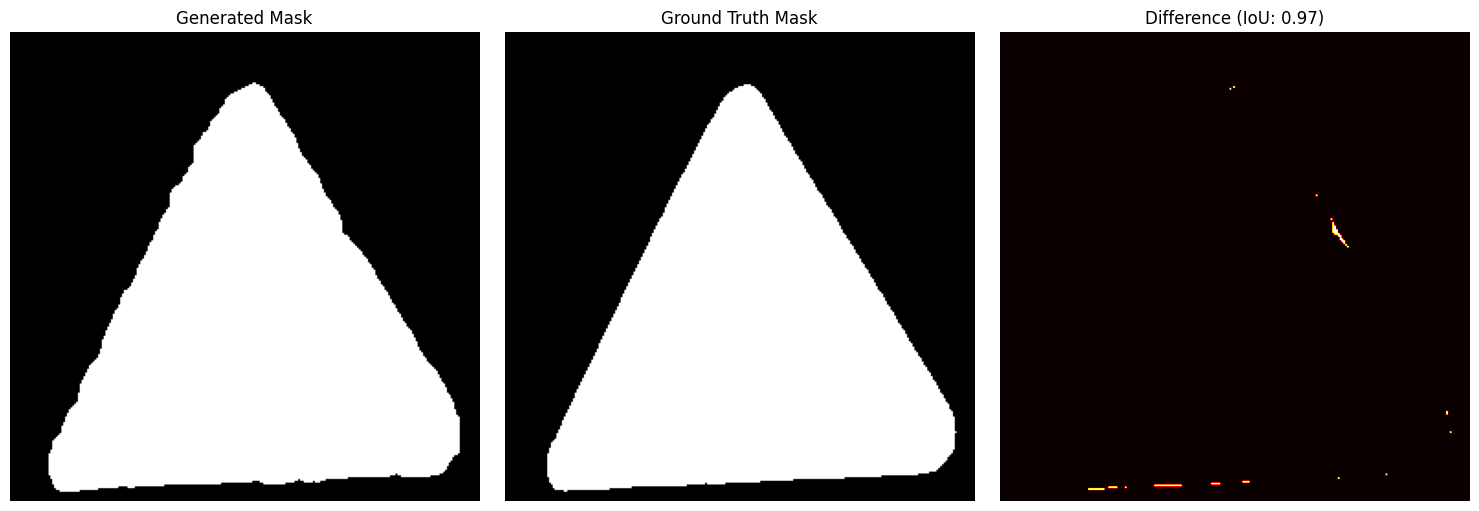


Performance Evaluation:
IoU for road_humps_2_groundtruth.png: 0.97


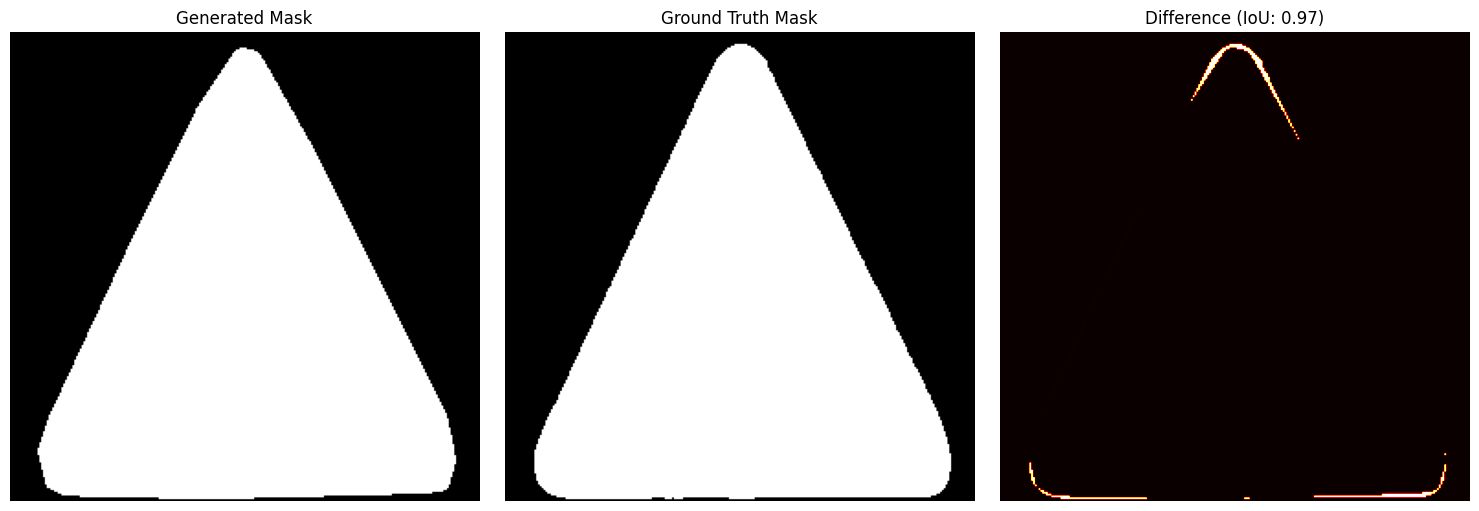


Performance Evaluation:
IoU for road_worksground.png: 0.95


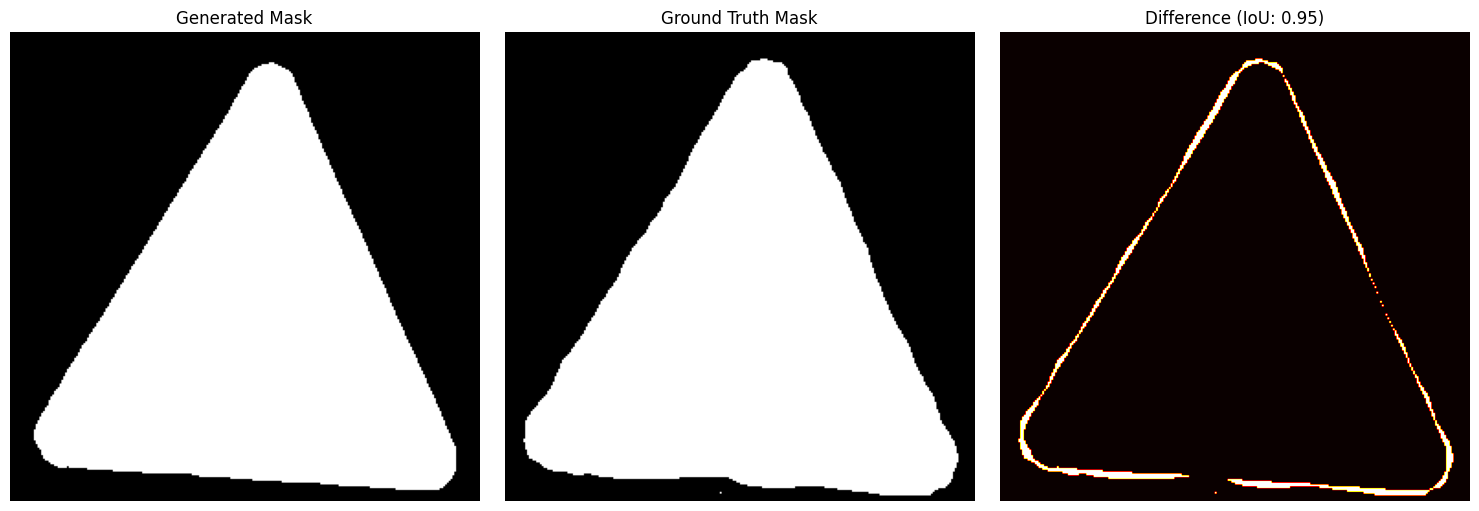


Performance Evaluation:
IoU for zebra_crossingground.png: 0.97


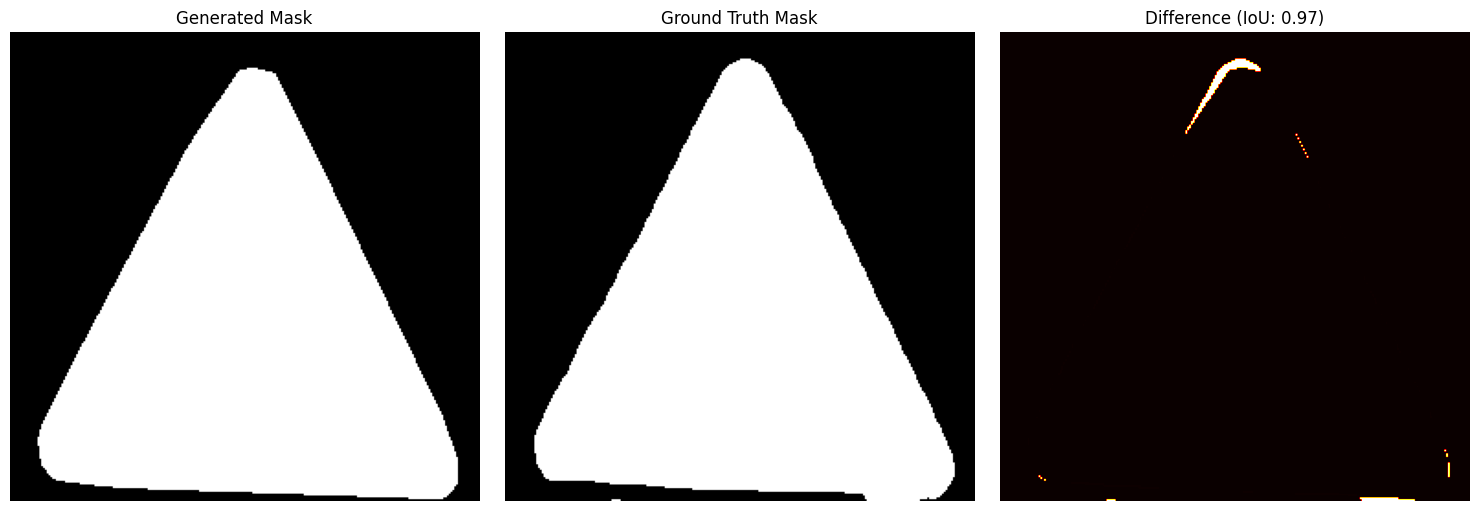

In [616]:
import time
masks=[]
for img_name in ["frail.png", "road_humps_1.png", "road_humps_2.png", "road_works.png", "zebra_crossing.png"]:
    scene_image = cv2.imread(data_dir + "/Task-4/" + img_name)
    start_time = time.time()
    mask, segmented_img = segment_warning_road_sign(scene_image)
    end_time = time.time()
    masks.append(mask)
    display_segmentation_results(scene_image, mask, segmented_img)
    print(f"Processing time for {img_name}: {end_time - start_time:.4f} seconds")

ground_truth_filenames = [
    "frail-groundtruthmask.png", 
    "road_humps_1_groundtruth.png", 
    "road_humps_2_groundtruth.png", 
    "road_worksground.png", 
    "zebra_crossingground.png"
]
for generated_mask, gt_filename in zip(masks, ground_truth_filenames):
    ground_truth = cv2.imread(data_dir + "/GroundTruth/" + gt_filename, cv2.IMREAD_GRAYSCALE)

    generated_mask_bin = (generated_mask > 0).astype(np.uint8)
    ground_truth_bin = (ground_truth > 0).astype(np.uint8)

    intersection = np.logical_and(generated_mask_bin, ground_truth_bin).sum()
    union = np.logical_or(generated_mask_bin, ground_truth_bin).sum()
    iou = intersection / union if union > 0 else 0

    print("\nPerformance Evaluation:")
    print(f"IoU for {gt_filename}: {iou:.2f}")

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title('Generated Mask')
    plt.imshow(generated_mask_bin, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Ground Truth Mask')
    plt.imshow(ground_truth_bin, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title(f'Difference (IoU: {iou:.2f})')
    difference = np.abs(generated_mask_bin - ground_truth_bin)
    plt.imshow(difference, cmap='hot') 
    plt.axis('off')

    plt.tight_layout()
    plt.show()